In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!python -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cthng123/hate-speech-detection-vietnamese")

print("Path to dataset files:", path)

100%|██████████| 230k/230k [00:00<00:00, 54.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/cthng123/hate-speech-detection-vietnamese/versions/1


In [5]:
!pip install -q transformers==4.41.2
!pip install -q pyvi
!pip install -q datasets
!pip install wordcloud
!pip install seaborn
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from collections import Counter
from wordcloud import WordCloud

#ML
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib

# DL
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Bidirectional, Dropout, concatenate, BatchNormalization, GlobalMaxPooling1D, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


# PLM
import os
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.data import Dataset
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/train_df.csv")
val_df = pd.read_csv("/content/drive/MyDrive/val_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test_df.csv")

train_df

,cmt_col,labels
0,cặc,1.0
1,đr hết thời cày rank bk còn ngợp,0.0
2,Diễn viên hô ni hút mà ngại gì mấy khác kk,0.0
3,Toàn bọn vô công rồi nghề ngồi sủa ăn lương th...,2.0
4,lên kim cương bố ỉa vào mồm mày với cái lối lê...,1.0
...,...,...
5161,Đánh ngu đẩy láo chết hét cái đầu buồi,2.0
5162,xinh mà ngu,1.0
5163,Trần ThanhThảo Tuyết Hoa bớt nc vs zai lạ,0.0
5164,Cái tội thích trai đẹp,0.0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cmt_col  5166 non-null   object 
 1   labels   5166 non-null   float64
dtypes: float64(1), object(1)
memory usage: 80.8+ KB


Visualization


In [9]:
def statistical(list):
    all_elements = [word for sentence in list for word in sentence.split()]
    unique_set = set(all_elements)
    count_unique = len(unique_set)
    return count_unique

print("Unique words in corpus:", statistical(train_df.cmt_col.tolist() + val_df.cmt_col.tolist() + test_df.cmt_col.tolist()))

Unique words in corpus: 10937


Max sentence len: 133


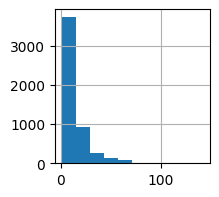

In [10]:
def visualize(input):
    longest_sentence = max(input.values, key=len)
    print(f"Max sentence len: {len(longest_sentence.split())}")

    ax = plt.figure(figsize=(2,2))
    seq_len = [len(i.split()) for i in input]
    pd.Series(seq_len).hist(bins = 10)
    plt.show()

visualize(train_df.cmt_col)

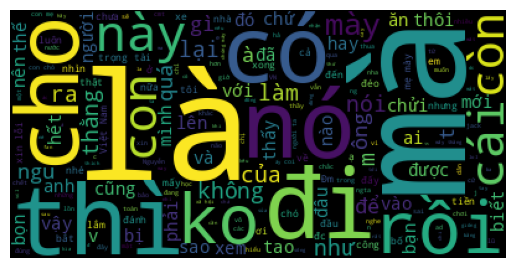

In [11]:
wordcloud2 = WordCloud().generate(' '.join(train_df['cmt_col']))
text3 = ' '.join(train_df['cmt_col'])
wordcloud2 = WordCloud().generate(text3)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

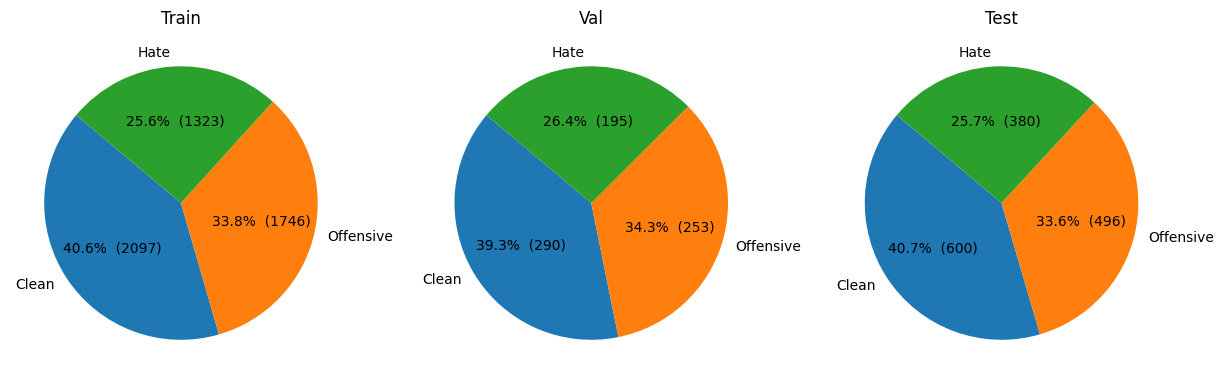

In [12]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

train_count = Counter(train_df.labels.values)
val_count = Counter(val_df.labels.values)
test_count = Counter(test_df.labels.values)
new_order = [0, 1, 2]
train_count = Counter({key: train_count[key] for key in new_order})
val_count = Counter({key: val_count[key] for key in new_order})
test_count = Counter({key: test_count[key] for key in new_order})

count_list = [train_count, val_count, test_count]
title_list = ["Train", "Val", "Test"]
labels_list = ["Clean", "Offensive", "Hate"]

plt.figure(figsize=(15, 12))
for idx, value in enumerate(count_list):
    plt.subplot2grid((1, 3), (0, idx))
    plt.pie(value.values(), labels = labels_list, autopct=make_autopct(value.values()), explode=[0, 0, 0], startangle=140)
    plt.title(title_list[idx])

DATA PREORICESSING


In [13]:
from google.colab import files

uploaded = files.upload()

Saving hate_norm.txt to hate_norm.txt


In [14]:
from google.colab import files

uploaded = files.upload()

Saving preprocess.py to preprocess.py


In [15]:
from preprocess import remove_http, normalize_acronyms, remove_emoji, remove_unnecessary_characters, word_segmentation
def text_preprocess(text):
    text = text.lower()
    text = remove_http(text)
    text = remove_unnecessary_characters(text)
    text = remove_emoji(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text)
    return text

train_text = list(map(text_preprocess, train_df['cmt_col']))
val_text = list(map(text_preprocess, val_df['cmt_col']))
test_text = list(map(text_preprocess, test_df['cmt_col']))

train_labels = train_df.labels.values.astype("int64")
val_labels = val_df.labels.values.astype("int64")
test_labels = test_df.labels.values.astype("int64")

In [16]:
tfvec = TfidfVectorizer()
train_tf_features = tfvec.fit_transform(train_text)
val_tf_features = tfvec.transform(val_text)
test_tf_features = tfvec.transform(test_text)

In [17]:
MODEL_PATH = '/content/drive/MyDrive/Data_processing'

ML


In [18]:
LR = LogisticRegression()
LR.fit(train_tf_features, train_labels)
pred = LR.predict(test_tf_features)

print(classification_report(pred, test_labels, digits=4))

              precision    recall  f1-score   support

           0     0.8767    0.7747    0.8225       679
           1     0.6310    0.6702    0.6501       467
           2     0.6737    0.7758    0.7211       330

    accuracy                         0.7419      1476
   macro avg     0.7271    0.7402    0.7312      1476
weighted avg     0.7536    0.7419    0.7453      1476



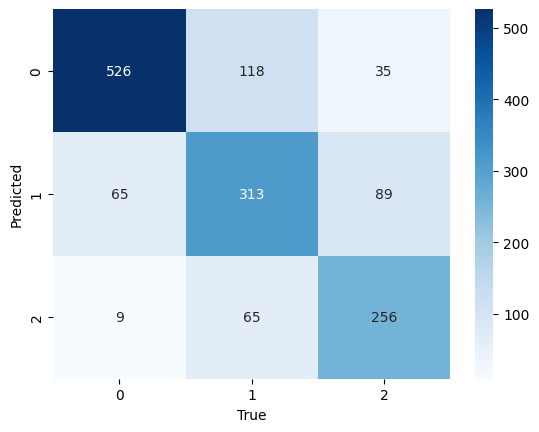

In [19]:
cf = pd.crosstab(pred, test_labels, rownames=(['Predicted']), colnames=(['True']))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues');

In [20]:
with open(f'{MODEL_PATH}/lr_74_prep.txt', 'w') as file:
    for item in pred.tolist():
        file.write(f"{item}\n")

In [21]:
svc = SVC()
svc.fit(train_tf_features, train_labels)
predict = svc.predict(test_tf_features)

print(classification_report(predict, test_labels, digits = 4))

              precision    recall  f1-score   support

           0     0.8833    0.7659    0.8204       692
           1     0.6331    0.6871    0.6590       457
           2     0.6895    0.8012    0.7412       327

    accuracy                         0.7493      1476
   macro avg     0.7353    0.7514    0.7402      1476
weighted avg     0.7629    0.7493    0.7529      1476



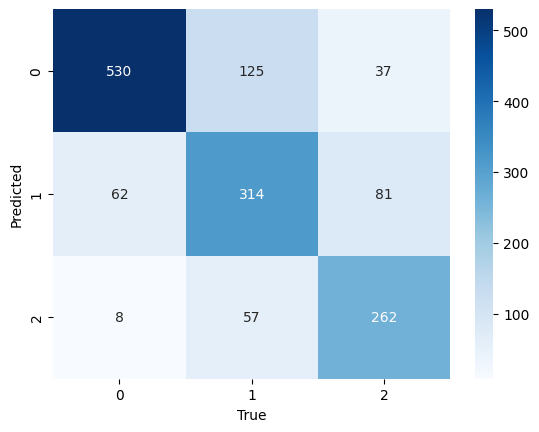

In [22]:
cf = pd.crosstab(predict, test_labels, rownames=(['Predicted']), colnames=(['True']))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues');

In [23]:
with open(f'{MODEL_PATH}/svc_76_prep.txt', 'w') as file:
    for item in predict.tolist():
        file.write(f"{item}\n")

In [24]:
joblib.dump(LR, f'{MODEL_PATH}/LR_74_prep_model.pkl')
joblib.dump(svc, f'{MODEL_PATH}/svc_76_prep_model.pkl')

['/content/drive/MyDrive/Data_processing/svc_76_prep_model.pkl']

DL


In [25]:
max_len = 128

word_tokenizer = Tokenizer(oov_token=-1)
word_tokenizer.fit_on_texts(train_df.cmt_col.values)

word_to_index = word_tokenizer.word_index
word_to_index['pad'] = 0
word_to_index['unk'] = -1
index_to_word = {i: w for w, i in word_to_index.items()}


def encoding(X):
    sentences = []
    for t in X:
        sentences.append(t)
    X = word_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["pad"])
    return X

X_train_encoded = encoding(train_text)
X_dev_encoded = encoding(val_text)
X_test_encoded = encoding(test_text)

In [26]:
num_words = len(word_to_index)
embedding_dim = 128
from tensorflow.keras.optimizers import Adam

def create_bilstm_model():
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(num_words, embedding_dim, input_length=max_len)(input_layer)
    bilstm_layer1 = Bidirectional(LSTM(50, dropout=0.2, return_sequences=True))(embedding_layer)
    bilstm_layer2 = Bidirectional(LSTM(32, dropout=0.5, return_sequences=False))(bilstm_layer1)

    output_layer = Dense(3, activation='softmax')(bilstm_layer2)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.002), metrics=['accuracy'])
    return model
model = create_bilstm_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 128, 128)            │         695,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128, 100)            │          71,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 800,883 (3.06 MB)

 Trainable params: 800,883 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
his = model.fit(X_train_encoded, to_categorical(train_labels, num_classes=3),
          validation_data = (X_dev_encoded, to_categorical(val_labels, num_classes=3)),
          batch_size=32, epochs = 3
)

Epoch 1/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4678 - loss: 0.5856 - val_accuracy: 0.6707 - val_loss: 0.4501
Epoch 2/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7878 - loss: 0.3402 - val_accuracy: 0.7249 - val_loss: 0.3891
Epoch 3/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8666 - loss: 0.2367 - val_accuracy: 0.7520 - val_loss: 0.4045


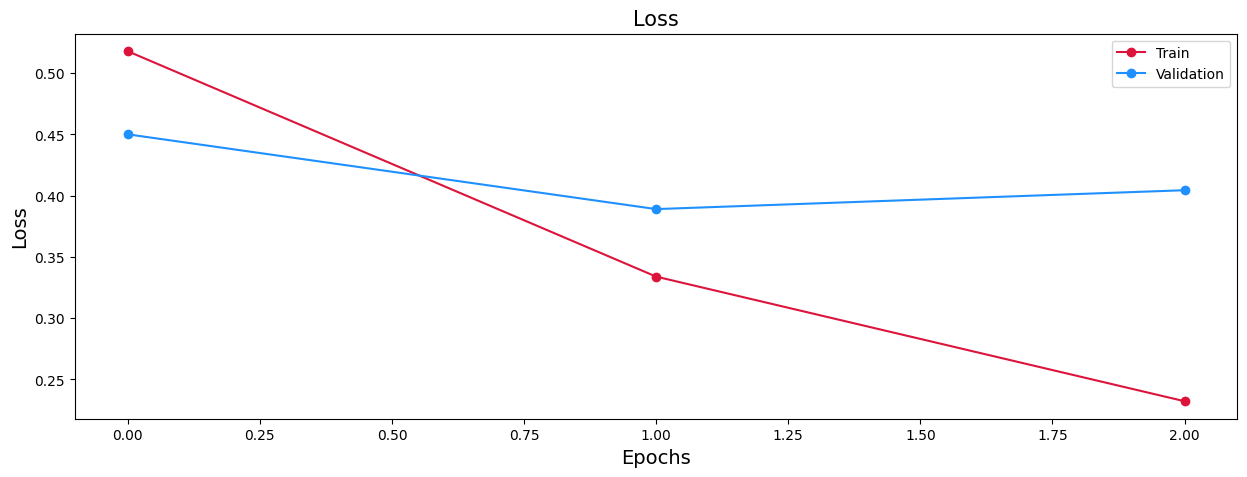

In [28]:
fig = plt.figure(figsize=(15, 5))
plt.plot(his.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(his.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/evaluation_DL.png', bbox_inches='tight')
plt.show()

In [29]:
pred = model.predict(X_test_encoded)
pred = np.argmax(pred, axis = -1)
print(classification_report(pred, test_labels, digits = 4))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0     0.8433    0.8447    0.8440       599
           1     0.7319    0.6237    0.6735       582
           2     0.6342    0.8169    0.7141       295

    accuracy                         0.7520      1476
   macro avg     0.7365    0.7618    0.7439      1476
weighted avg     0.7576    0.7520    0.7508      1476



In [30]:
with open(f'{MODEL_PATH}/BiLSTM_76_prep.txt', 'w') as file:
    for item in pred.tolist():
        file.write(f"{item}\n")

In [31]:
model.save(f'{MODEL_PATH}/BiLSTM_76.h5')

**PLM**

In [32]:
TRAIN_PATH = "/content/drive/MyDrive/train_df.csv"
VAL_PATH = "/content/drive/MyDrive/val_df.csv"
TEST_PATH = "/content/drive/MyDrive/test_df.csv"
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['cmt_col', 'labels'],
        num_rows: 5166
    })
    val: Dataset({
        features: ['cmt_col', 'labels'],
        num_rows: 738
    })
    test: Dataset({
        features: ['cmt_col', 'labels'],
        num_rows: 1476
    })
})

In [33]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            labels = df.iloc[row, col]
            if   labels == 0: one_hot = [1, 0, 0] # clean
            elif labels == 1: one_hot = [0, 1, 0] # offensive
            elif labels == 2: one_hot = [0, 0, 1] # hate
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

y_train = make_outputs(train_df)
y_val = make_outputs(val_df)
y_test = make_outputs(test_df)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[1]

Train outputs: (5166, 1, 3)
Validate outputs: (738, 1, 3)
Test outputs: (1476, 1, 3)


array([[1, 0, 0]], dtype=uint8)

In [34]:
from transformers import AutoTokenizer

# Định nghĩa tokenizer
PRETRAINED_MODEL = 'uitnlp/visobert'
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.model_max_length

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/471k [00:00<?, ?B/s]

1000000000000000019884624838656

In [35]:
def tokenize_function(dataset):
    clean_texts = list(dataset['cmt_col'])
    return tokenizer(clean_texts, max_length=256, padding='max_length', truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

Map:   0%|          | 0/5166 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/1476 [00:00<?, ? examples/s]

input_ids of sentence 1484: [0, 5513, 42, 1023, 9188, 688, 8712, 48, 14636, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [36]:
MAX_SEQUENCE_LENGTH = 256
BATCH_SIZE = 18

STEPS_PER_EPOCH = (len(raw_datasets['train']) // BATCH_SIZE)
VALIDATION_STEPS = (len(raw_datasets['val']) // BATCH_SIZE)
EPOCHS = 15

In [37]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[:-2]).with_format('tensorflow')

def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.uint8, name=None))>

In [38]:
bert_model = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True, from_pt=True)

def bert_embedding(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.hidden_states[-1][:, 0, :]
# Hàm tạo model
def create_model(optimizer):
    input_ids = Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(256,), dtype=tf.int32, name="attention_mask")

    # Sử dụng Lambda Layer để lấy embedding từ BERT
    bert_output = Lambda(bert_embedding, output_shape=(768,))([input_ids, attention_mask])

    # Thêm các tầng Dense
    x = Dropout(0.2)(bert_output)
    x = Dense(128, activation="relu")(x)
    output = Dense(3, activation="softmax")(x)

    # Xây dựng model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    # Compile model
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

# Khởi tạo optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# Tạo model
model = create_model(optimizer)

# Kiểm tra kiến trúc
model.summary()
type(optimizer)


pytorch_model.bin:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFXLMRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         98,432 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │            387 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 98,819 (386.01 KB)

 Trainable params: 98,819 (386.01 KB)

 Non-trainable params: 0 (0.00 B)

keras.src.optimizers.adam.Adam

In [39]:
def lr_schedule(epoch, lr):
    new_lr = float(lr * 0.9)  # Đảm bảo kiểu float
    return max(new_lr, 1e-6)   # Tránh giảm quá nhỏ

# Gán vào callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

In [40]:
model = create_model(optimizer)

In [41]:
history = model.fit(
    train_tf_dataset.repeat(),
    validation_data=val_tf_dataset.repeat(),
    validation_steps=VALIDATION_STEPS,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15,
    callbacks=[lr_callback],)



Epoch 1: LearningRateScheduler setting learning rate to 1.7999999545281754e-05.
Epoch 1/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 107s 308ms/step - accuracy: 0.3762 - loss: 1.3662 - val_accuracy: 0.5515 - val_loss: 0.9786 - learning_rate: 1.8000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.6199998935917392e-05.
Epoch 2/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 139s 484ms/step - accuracy: 0.5037 - loss: 1.0273 - val_accuracy: 0.6260 - val_loss: 0.8663 - learning_rate: 1.6200e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.457999969716184e-05.
Epoch 3/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 142s 495ms/step - accuracy: 0.5862 - loss: 0.9193 - val_accuracy: 0.6463 - val_loss: 0.8057 - learning_rate: 1.4580e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.3121999563736608e-05.
Epoch 4/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 91s 316ms/step - accuracy: 0.6091 - loss: 0.8532 - val_accuracy: 0.6558 - val_loss: 0.7706 - learning_rate: 1.3122e-05

Epoch 5: LearningRateScheduler settin

In [42]:
model.save('/content/drive/MyDrive/Data_processing/viso_noprep_80.h5')

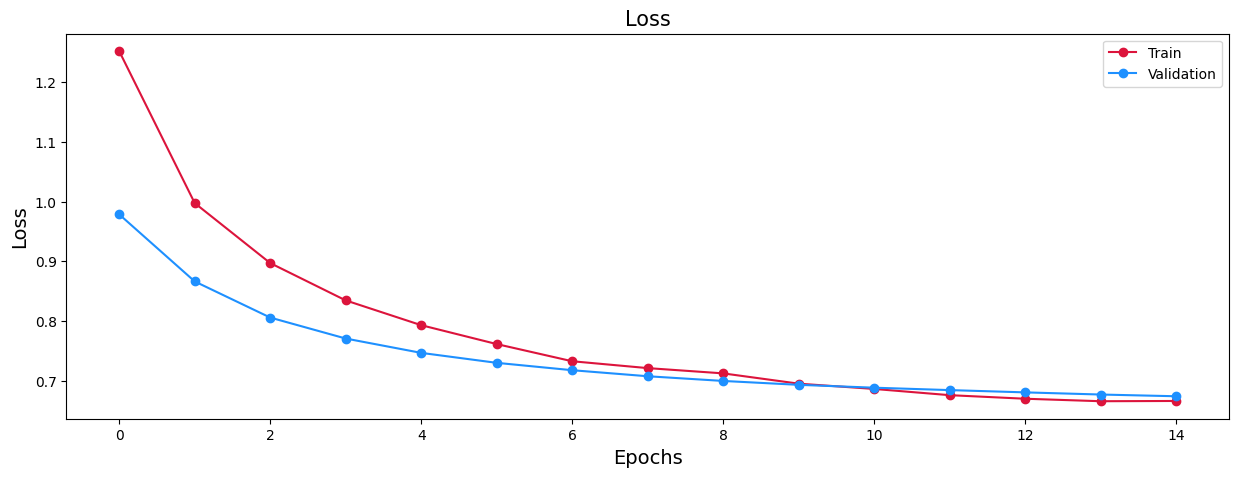

In [43]:
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/viso_noprep.png', bbox_inches='tight')
plt.show()

In [44]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_pred = model.predict(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
y_pred_arg = np.argmax(y_pred, axis=-1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 270ms/step


*DEMO*

In [45]:
# ML
reloaded_LR_model = joblib.load(f'{MODEL_PATH}/LR_74_prep_model.pkl')
reloaded_svc_model = joblib.load(f'{MODEL_PATH}/svc_76_prep_model.pkl')
# DL
reloaded_DL_model = create_bilstm_model()
reloaded_DL_model.load_weights(f'{MODEL_PATH}/BiLSTM_76.h5')
# PLM
reloaded_PLM_model = create_model(optimizer)
reloaded_PLM_model.load_weights(f'{MODEL_PATH}/viso_noprep_80.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
import warnings
warnings.filterwarnings('ignore')

def predict(model, input, batch_szie = 1, verbose = 0):
    pred = model.predict(input, batch_size = batch_szie, verbose = verbose)
    pred = np.argmax(pred, axis=-1)
    return pred

def transform_labels(predict):
    if predict == 0:
        return "CLEAN"
    elif predict == 1:
        return "OFFENSIVE"
    else:
        return "HATE SPEECH"


text = input('Enter your sentence: ')
# ML
text_pre = text_preprocess(text)
tf_text = tfvec.transform([text_pre])

LR_pred = reloaded_LR_model.predict(tf_text)
SVM_pred = reloaded_svc_model.predict(tf_text)

# DL
text_pre = text_preprocess(text)
DL_pred = predict(reloaded_DL_model, encoding([text_pre]))

# PLM
text_pre = text
tokenized_input = tokenizer(text_pre, max_length = 256 , padding = 'max_length', truncation = True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}

PLM_pred = predict(reloaded_PLM_model, Dataset.from_tensor_slices(features))


print(f"Logistic Regression: {transform_labels(LR_pred)}")
print(f"Support Vector Machine: {transform_labels(SVM_pred)}")
print(f"BiLSTM: {transform_labels(DL_pred)}")
print(f"Visobert: {transform_labels(PLM_pred)}")

Enter your sentence: thằng bê đê không biết nhục à?
Logistic Regression: HATE SPEECH
Support Vector Machine: HATE SPEECH
BiLSTM: OFFENSIVE
Visobert: HATE SPEECH
